## Preface



If need be&#x2026;



In [2]:
!pip install -r requirements.txt

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:

| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|t,m|j|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [4]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

Note that in some cases not the food items for the FCT (e.g., for Niger) are **not** yet all matched up (&ldquo;harmonized&rdquo;) with food labels indexed by `j` in the expenditure,
consumption and price datasets.



In [5]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `result`.



In [6]:
import cfe

result = cfe.Regression(y=np.log(x.stack()),d=z)

result.get_beta().sort_values(ascending=False) # Check sanity...

Missing dependencies for OracleDemands.


j
Fish (fresh)      0.883097
Milk (fresh)      0.827242
Oranges           0.744376
Biscuits          0.744297
Bread             0.664049
Other Fruits      0.654502
Sorghum           0.637732
Chapati           0.618714
Sweet Bananas     0.589637
Other Veg.        0.583743
Soda              0.583512
Sim Sim           0.569816
Rice              0.533867
Tomatoes          0.481396
Goat              0.474693
Mangos            0.462053
Matoke            0.436465
Fish (dried)      0.435164
Beef              0.423323
Ground Nuts       0.422764
Maize             0.415978
Tea               0.414507
Cooking Oil       0.412335
Waragi            0.412290
Cabbages          0.396744
Pork              0.382943
Dodo              0.366859
Millet            0.343900
Eggs              0.339091
Onions            0.334354
Sweet Potatoes    0.323075
Beans             0.313003
Peas              0.277502
Cassava           0.148392
Salt              0.143707
Name: beta, dtype: float64

Make this persistent&#x2026;



In [7]:
result.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [8]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [9]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          55402.334433
Protein          1547.404473
Fiber             742.201250
Folate          11408.378744
Calcium         18036.100651
Carbohydrate     7357.420318
Iron              430.532922
Niacin            435.910189
Riboflavin         39.120370
Thiamin            46.466908
Vitamin A        9980.391620
Vitamin B-12       58.596619
Vitamin B-6        52.692769
Vitamin C        5509.918723
Zinc              239.617857
dtype: float64

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [10]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

Now, what proportion of `hh_rwi` do households consume?



In [11]:
# Match up nutrient names
use = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use]/hh_rwi[use]).dropna()

nutrient_ratio

n                                                   Energy   Protein  \
t       m       i                                                      
2019-20 Central 1013000201                        4.315401  4.224921   
                1013000202                        0.737862  1.073279   
                1013000204                        5.254213  5.366128   
                1021000108                        1.045822  1.057514   
                1021000109                        0.943360  1.040641   
...                                                    ...       ...   
        Western _62                               1.159015  1.651353   
                _67                               2.251584  2.911540   
                a98bebba177243668464e31f6d2bb92d  0.749378  1.011155   
                acb16f9b068549d8a80a37c9d638742f  0.717293  1.049682   
                d10a687889de469687377204195f3db0  0.837022  1.035757   

n                                                    Fiber    Folate  \
t       m       i                                                      
2019-20 Central 1013000201                        3.452184  3.315372   
                1013000202                        0.581578  0.781295   
                1013000204                        3.932774  5.119594   
                1021000108                        0.828362  0.915560   
                1021000109                        0.728639  0.855610   
...                                                    ...       ...   
        Western _62                               1.139710  1.354044   
                _67                               2.082708  2.773740   
                a98bebba177243668464e31f6d2bb92d  0.853133  0.875735   
                acb16f9b068549d8a80a37c9d638742f  0.721907  0.884114   
                d10a687889de469687377204195f3db0  0.836349  0.968754   

n                                                  Calcium  Carbohydrate  \
t       m       i                                                          
2019-20 Central 1013000201                        1.835499      6.168401   
                1013000202                        0.289181      0.805799   
                1013000204                        3.734277     10.548955   
                1021000108                        0.515113      1.475925   
                1021000109                        0.530407      1.547699   
...                                                    ...           ...   
        Western _62                               0.654531      2.296579   
                _67                               1.555587      6.017176   
                a98bebba177243668464e31f6d2bb92d  0.347700      1.638238   
                acb16f9b068549d8a80a37c9d638742f  0.344924      1.300708   
                d10a687889de469687377204195f3db0  0.439198      1.744392   

n                                                      Iron    Niacin  \
t       m       i                                                       
2019-20 Central 1013000201                         6.230978  3.728368   
                1013000202                         0.761108  0.759334   
                1013000204                        10.162579  5.229892   
                1021000108                         1.621361  0.921526   
                1021000109                         0.815182  0.956974   
...                                                     ...       ...   
        Western _62                                1.508047  1.482379   
                _67                                5.413554  2.875411   
                a98bebba177243668464e31f6d2bb92d   0.992159  0.953869   
                acb16f9b068549d8a80a37c9d638742f   0.865501  0.902626   
                d10a687889de469687377204195f3db0   1.512446  0.961419   

n                                                 Riboflavin   Thiamin  \
t       m       i                                                        
2019-20 Central 1013000201             

Graph ratios of adequacy for particular nutrients



<IPython.core.display.Javascript object>


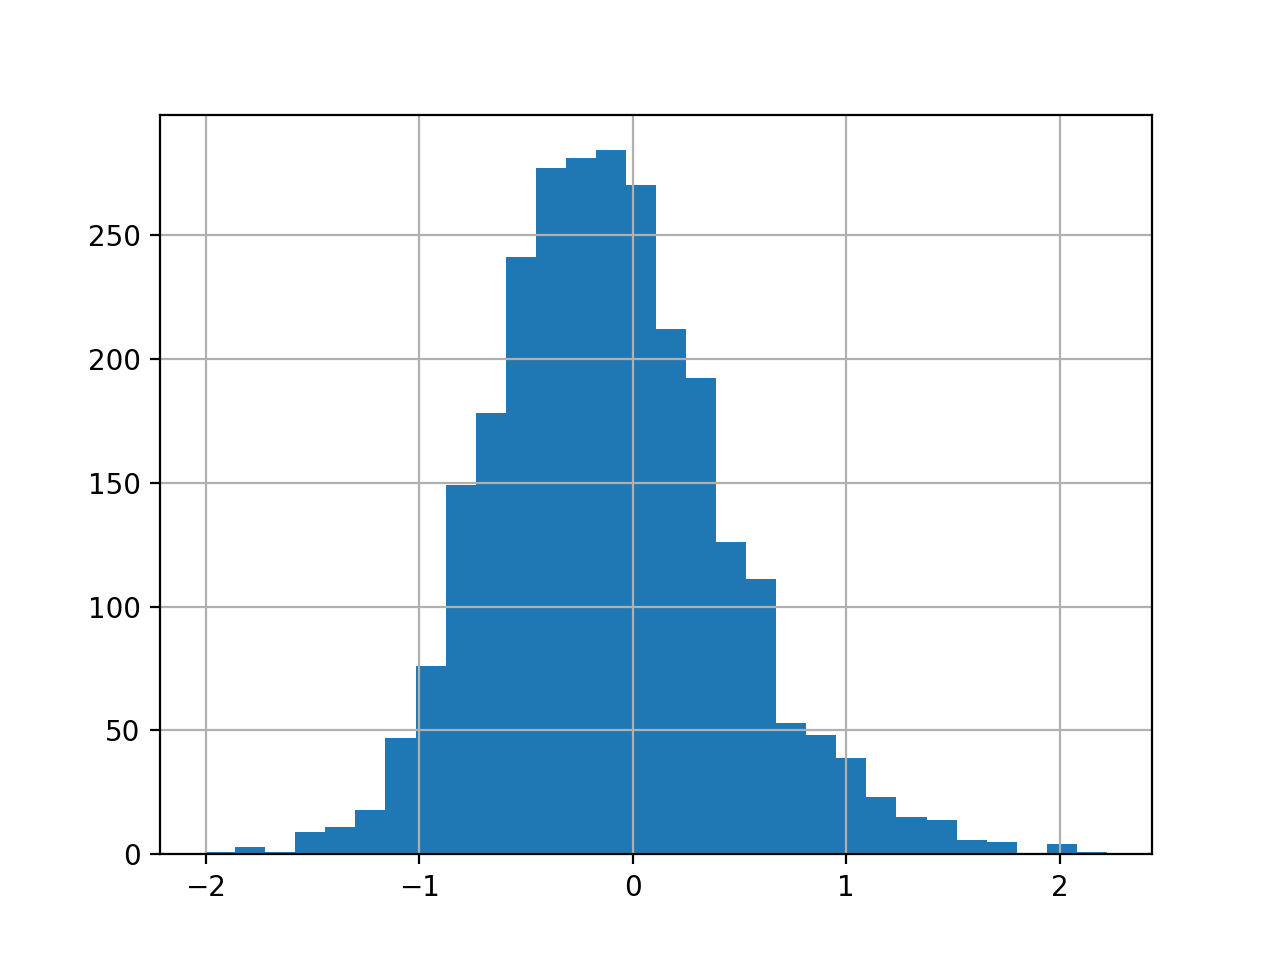

<AxesSubplot:>

In [14]:
%matplotlib notebook
np.log(nutrient_ratio['Energy']).hist(bins=30)